# Dataset & Dataloader

## `torch.utils.data.Dataset` : Dataset's role

### 1. Read & Split

1. Read dataset
2. Shuffle before split into train/valid/test set
3. Split dataset into train/valid/test set


### 2. Preprocessing

1. Remove unnecessary rows
    - ex)high null ratio
    
2. Standardization/Scaling training set
    - Standard
    - Min/Max Scaling
    - No need to apply to valid/test set
 
## `torch.utils.data.DataLoader` : Dataloader's role
 
### 3. Iterator

1. Shuffle for each epoch
2. Get tensor chunk with mini-batch size
3. Yield mini-batch for each iteration

* * * 

# Load dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [3]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


# Dataset & DataLoader

### `torch.utils.data.Dataset`

```
class CustomDataset(Dataset):
    
    def __init__(self, *args, **kwargs):
        ...
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
```



### `torch.utils.data.DataLoader`

```
dataloader = DataLoader(
    dataset=CustomDataset(x[0], y[0]),
    batch_size=batch_size,
    shuffle=True,
)
```

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
        super().__init__()
        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [7]:
# Convert data to torch tensor
data = torch.from_numpy(df.values).float()

# Split to data and label
x = data[:, :10]
y = data[:, -1:]

In [8]:
# Define train / validation / test set ratio
ratios = [.6, .2, .2]

data_size = data.shape[0]
train_count = int(data_size * ratios[0])
valid_count = int(data_size * ratios[1])
test_count = data_size - train_count - valid_count

counts = [train_count, valid_count, test_count]

In [9]:
# Split data

# random permutation
indices = torch.randperm(data_size)

# shuffle based on random permutation
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(counts, dim=0)
y = y.split(counts, dim=0)


# x[0], y[0] training set
# x[1], y[1] validation set
# x[2], y[2] test set

In [10]:
batch_size = 128

train_loader = DataLoader(
    dataset=CustomDataset(x[0], y[0]),
    batch_size=batch_size,
    shuffle=True, # Allow shuffling only for training set.
)

valid_loader = DataLoader(
    dataset=CustomDataset(x[1], y[1]),
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=CustomDataset(x[2], y[2]),
    batch_size=batch_size,
    shuffle=False,
)

## Build Model & Optimizer

In [11]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
  (9): Sigmoid()
)

In [12]:
optimizer = optim.Adam(model.parameters())

## Train

In [13]:
from copy import deepcopy

In [14]:
# hyperparameters
n_epochs = 10000
print_interval = 200
early_stop = 100

In [15]:
lowest_loss = np.inf
best_model = None

lowest_epoch = np.inf

In [16]:
train_history = []
valid_history = []

for i in range(n_epochs):
    
    model.train()
    
    train_loss = 0
    valid_loss = 0
    
    y_hat = []
    
    for x_i, y_i in train_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss += float(loss)
        
        
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        
        for x_i, y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(valid_loader)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    
    if (i+1) % print_interval == 0:
        print('Epoch %d: train_loss =%.4e / valid_loss=%4.e / lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if (early_stop > 0) and (lowest_epoch + early_stop < i + 1):
            print("No improvement during last %d epochs." % early_stop)
            break
            
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)    

Epoch 200: train_loss =1.3586e+00 / valid_loss=4e-01 / lowest_loss=4.3388e-01
Epoch 400: train_loss =9.0239e-01 / valid_loss=3e-01 / lowest_loss=2.5263e-01
Epoch 600: train_loss =8.9323e-01 / valid_loss=2e-01 / lowest_loss=2.2999e-01
Epoch 800: train_loss =8.4706e-01 / valid_loss=2e-01 / lowest_loss=2.1962e-01
Epoch 1000: train_loss =8.6948e-01 / valid_loss=2e-01 / lowest_loss=2.1226e-01
Epoch 1200: train_loss =8.2605e-01 / valid_loss=2e-01 / lowest_loss=2.0590e-01
Epoch 1400: train_loss =7.9738e-01 / valid_loss=2e-01 / lowest_loss=1.9809e-01
Epoch 1600: train_loss =7.5371e-01 / valid_loss=2e-01 / lowest_loss=1.9073e-01
Epoch 1800: train_loss =7.9330e-01 / valid_loss=2e-01 / lowest_loss=1.8215e-01
Epoch 2000: train_loss =7.1377e-01 / valid_loss=2e-01 / lowest_loss=1.7197e-01
Epoch 2200: train_loss =6.8032e-01 / valid_loss=2e-01 / lowest_loss=1.5968e-01
Epoch 2400: train_loss =6.4162e-01 / valid_loss=1e-01 / lowest_loss=1.4810e-01
Epoch 2600: train_loss =6.6098e-01 / valid_loss=1e-01 / 

<All keys matched successfully>

### plot loss history

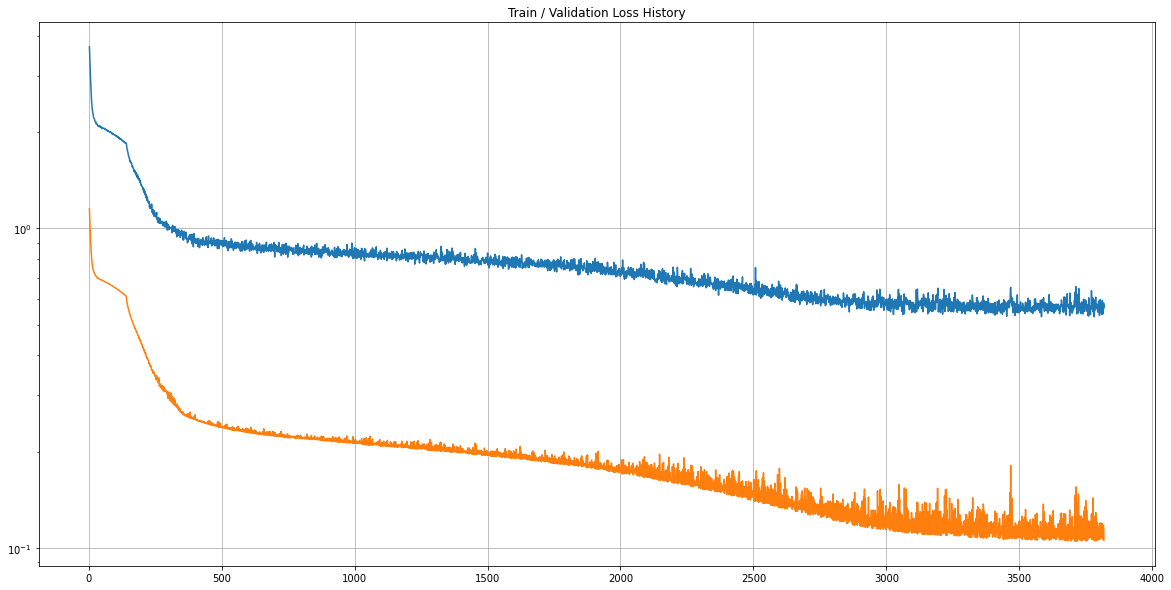

In [17]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Validation Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:]
)
plt.yscale('log')
plt.show()

## Prediction on test data

In [18]:
test_loss = 0
y_hat = []

model.eval()

with torch.no_grad():
    for x_i, y_i in test_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        test_loss += loss
        
        y_hat += [y_hat_i]
        

        
test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 1.3990e-01


In [19]:
correct_count = (y[2] == (y_hat > 0.5)).sum()
total_count = float(y[2].size(0))

print("Test accuracy: %.4f" % (correct_count / total_count))

Test accuracy: 0.9391


# Reference

- Fast Campus NLP Online Course